#### varaibles
- real gdp per capita growth - trend + cycle of real values? diff og gdp real per capita
- inflation = inflation trend + measurement errors???
- short rate = inflation trend + real rate trend 
- long rate = inflation trend + real rate trend + term trend
- inflation expectations??
- growth expextations??
- 

In [79]:
import Pkg
Pkg.activate("../")

include("../src/TCVAR.jl")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


Main.TCVAR

In [80]:
using .TCVAR
using DataFrames, XLSX, TimeSeries
using Statistics
using LinearAlgebra
using Plots


In [5]:
df = DataFrame(XLSX.readtable("../../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = TimeArray(df; timestamp = :observation_date)

gdp = percentchange(data_source[:A939RX0Q048SBEA], :log) .* 400
cpi = percentchange(data_source[:GDPDEF], :log) .* 400

data = merge(gdp, cpi, data_source[[:TB3MS, :GS10]])

presample, data = from(to(data, Date(1959, 12, 31)), Date(1955, 01, 01)), from(data, Date(1960, 01,01))

term =  presample[:GS10] .- presample[:TB3MS]
real_rate = presample[:TB3MS] .- presample[:GDPDEF] 

presample = merge(presample[[:A939RX0Q048SBEA, :GDPDEF]], real_rate, term)


20×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1955-01-01 to 1959-10-01
┌────────────┬─────────────────┬──────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF   │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼──────────┼──────────────┼────────────┤
│ 1955-01-01 │         9.59447 │  1.87642 │    -0.656424 │       1.43 │
│ 1955-04-01 │         4.86269 │  1.63468 │    -0.154681 │       1.28 │
│ 1955-07-01 │         3.55007 │  2.78686 │    -0.926861 │       1.09 │
│ 1955-10-01 │        0.446868 │  3.94375 │     -1.60375 │       0.57 │
│ 1956-01-01 │        -3.20292 │  3.99034 │     -1.66034 │       0.57 │
│ 1956-04-01 │         1.66872 │  2.34704 │     0.222957 │       0.51 │
│ 1956-07-01 │        -2.22651 │  4.98746 │     -2.40746 │       0.69 │
│ 1956-10-01 │         4.54684 │  1.61178 │      1.41822 │       0.44 │
│     ⋮      │        ⋮        │    ⋮     │      ⋮       │     ⋮      │
│ 1958-04-01 │         1.08548 │   1.1464 │      -0.1864 │   

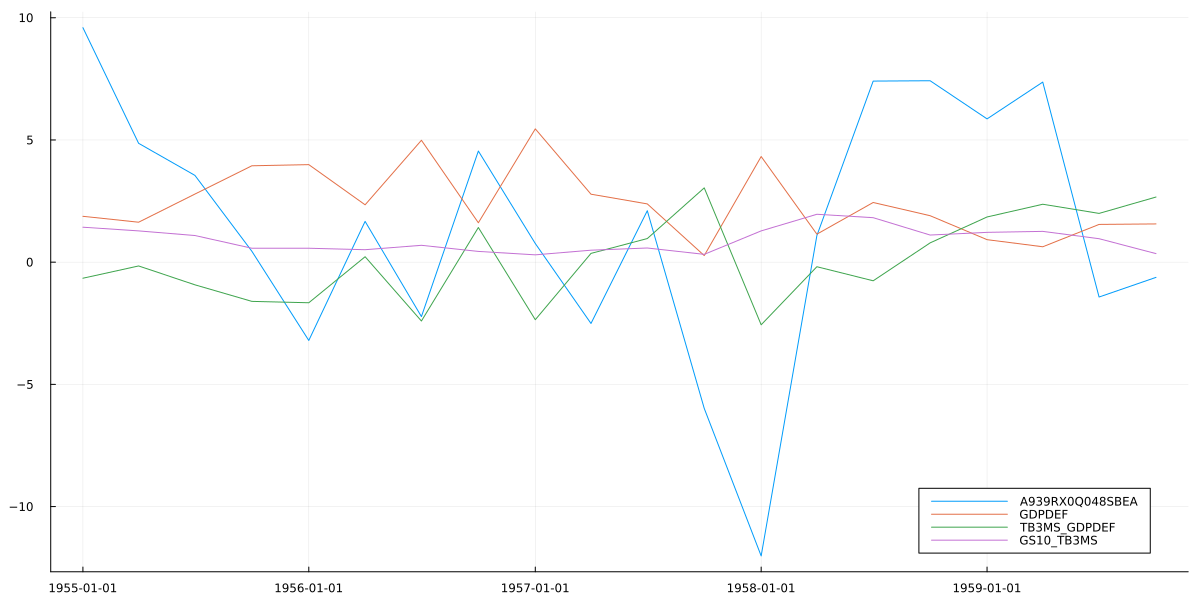

In [6]:
plot(presample; size=(1200, 600))

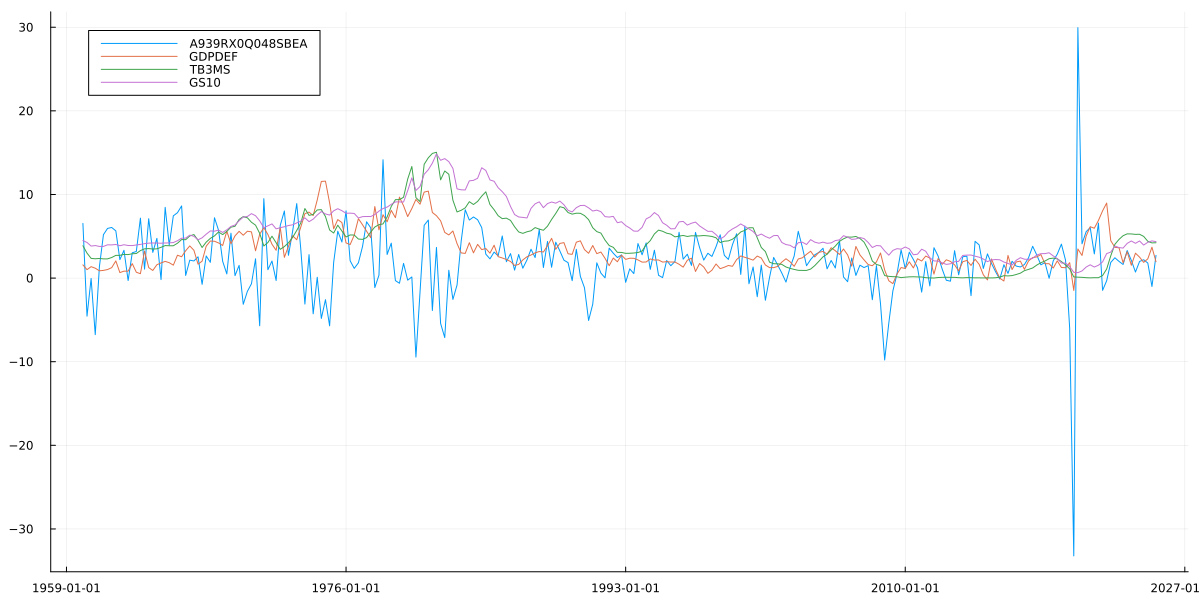

In [7]:
plot(data; size=(1200, 600))

In [8]:
presample_mean = mean(presample)
presample_mean = round.(presample_mean, digits=2)
display("presample mean")
display(presample_mean)

presample_variance = var(presample)
presample_variance = round.(presample_variance, digits=2)
display("presample variance")
display(presample_variance)
display(presample_variance .^ .5) 

"presample mean"

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1959-10-01 to 1959-10-01
┌────────────┬─────────────────┬────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼────────┼──────────────┼────────────┤
│ 1959-10-01 │            1.44 │   2.43 │         0.12 │       0.91 │
└────────────┴─────────────────┴────────┴──────────────┴────────────┘

"presample variance"

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1959-10-01 to 1959-10-01
┌────────────┬─────────────────┬────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼────────┼──────────────┼────────────┤
│ 1959-10-01 │           27.36 │   2.08 │         3.05 │       0.25 │
└────────────┴─────────────────┴────────┴──────────────┴────────────┘

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1959-10-01 to 1959-10-01
┌────────────┬─────────────────┬─────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF  │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼─────────┼──────────────┼────────────┤
│ 1959-10-01 │         5.23068 │ 1.44222 │      1.74642 │        0.5 │
└────────────┴─────────────────┴─────────┴──────────────┴────────────┘

In [9]:
n = 4 #number of observatin variables

priors = (
        initial_trend_mean = values(presample_mean)[1,:],
        initial_cycle_mean = zeros(n),
        initial_trend_covariance = diagm(fill(1,n)),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2.5, 5, 5, 5] ./ 400),
        cycle_coeff_mean = zeros(n, n),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(values(presample_variance)[1,:]), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [1.44, 2.43, 0.12, 0.91], initial_cycle_mean = [0.0, 0.0, 0.0, 0.0], initial_trend_covariance = [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1], trend_covariance_df = 100, trend_covariance_mean = [0.00625 0.0 0.0 0.0; 0.0 0.0125 0.0 0.0; 0.0 0.0 0.0125 0.0; 0.0 0.0 0.0 0.0125], cycle_coeff_mean = [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [27.36 0.0 0.0 0.0; 0.0 2.08 0.0 0.0; 0.0 0.0 3.05 0.0; 0.0 0.0 0.0 0.25], cycle_covariance_df = 6)

In [10]:
priors.cycle_covariance_mean

4×4 Matrix{Float64}:
 27.36  0.0   0.0   0.0
  0.0   2.08  0.0   0.0
  0.0   0.0   3.05  0.0
  0.0   0.0   0.0   0.25

In [11]:
observation_tend_mapping  = [1 0 0 0 
                             0 1 0 0 
                             0 1 1 0 
                             0 1 1 1 ]

trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = TCVAR.gibs_sampler(values(data), observation_tend_mapping, priors; burnin = 50_000, n_samples = 50_000, thin=25)

trend_states_mean, trend_states_lower, trend_states_upper = TCVAR.compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = TCVAR.compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([4.21270599765563 -0.9795806119449911 0.5597672575599827 0.21608622870642816; -6.879366868283356 -1.5345564340007847 -0.2818608675944572 0.03786053152399746; … ; -2.7042506982525394 0.9526880953484893 1.274083396698083 0.35971723964492536; 1.014605341156815 -0.7663512875958004 1.3055500221291372 0.2830439366813647], [3.2757730512782683 -2.2407646564860455 -1.0187191506157116 -1.5556858789497936; -7.819090864829512 -2.7931596960963105 -1.892440412691556 -1.7310005068857746; … ; -3.78001428956917 -1.0565576302071729 -1.6546466003135087 -3.7540085376144927; -0.06778350066490259 -2.7908031042400565 -1.654900902258879 -3.8386493493661336], [5.292579289443441 0.21464481805134314 2.1873346948933654 2.019428958795571; -5.796115548662072 -0.33671768078373154 1.3431625515690744 1.9530400149315617; … ; -1.6160969372011886 3.441997527754401 4.287979625642094 4.8730063561801105; 2.1179994051439537 1.7647475571999311 4.321438432379168 4.794887185043012])

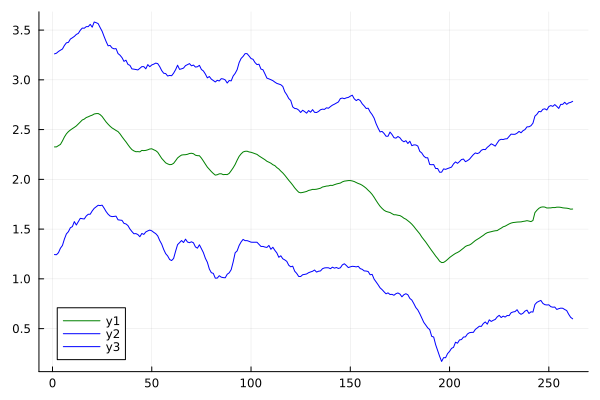

In [12]:
st = 1
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

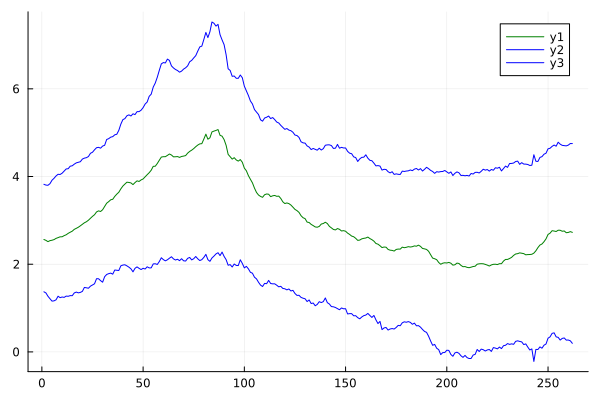

In [13]:
st = 2
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

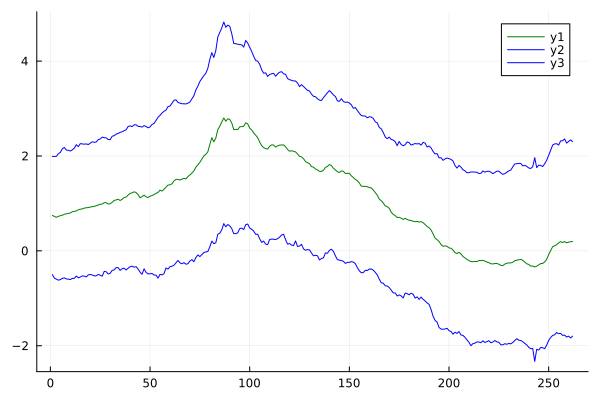

In [14]:
st = 3
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

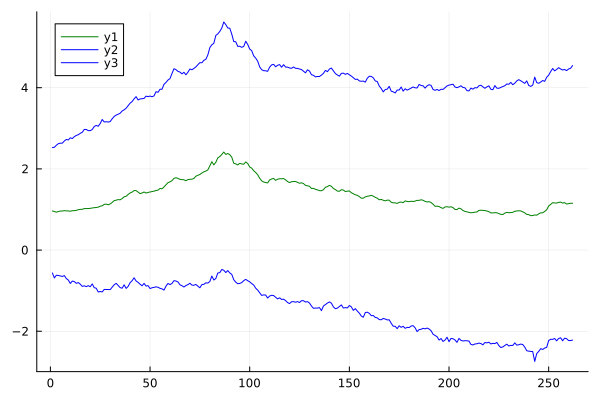

In [15]:
st = 4
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

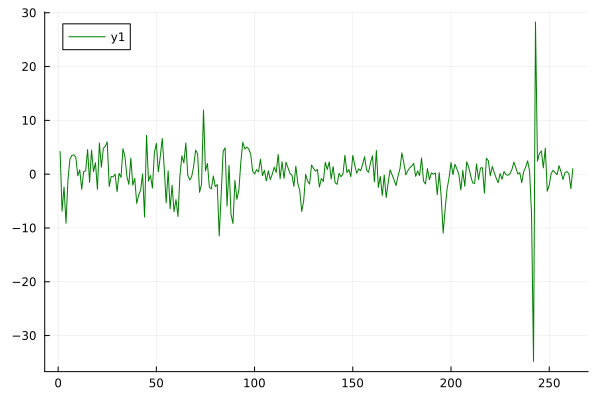

In [16]:
st=1
plot(cycle_states_mean[:,st], color="green" )

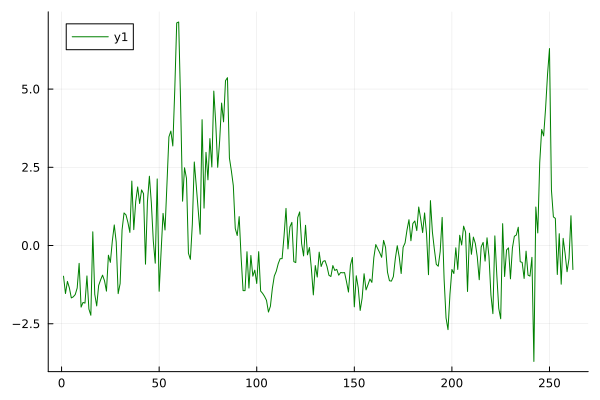

In [17]:
st=2
plot(cycle_states_mean[:,st], color="green" )

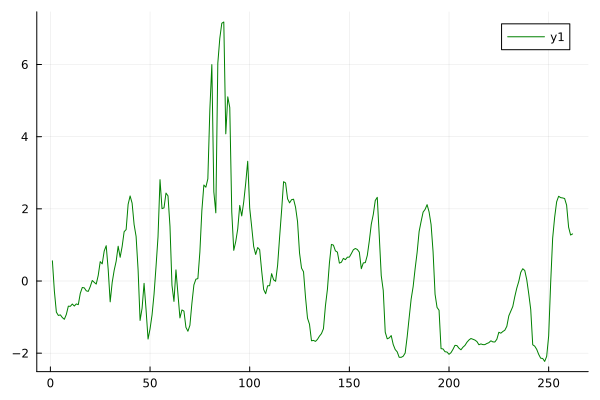

In [18]:
st=3
plot(cycle_states_mean[:,st], color="green" )

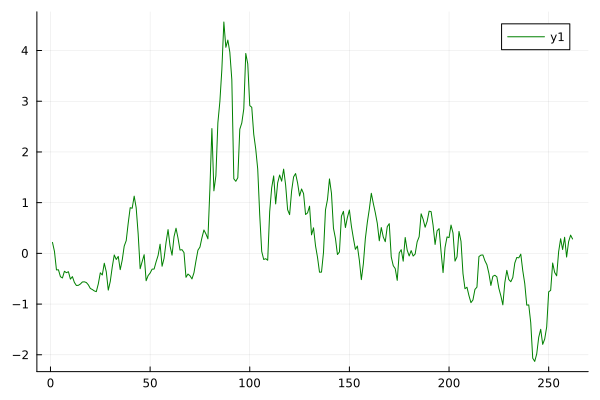

In [19]:
st=4
plot(cycle_states_mean[:,st], color="green" )

In [20]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Στ1    0.0081    0.0029    0.0001   2098.7134   1848.1835    0.9998   ⋯
         Στ2   -0.0000    0.0039    0.0001   1763.0986   1846.4563    0.9998   ⋯
         Στ3    0.0003    0.0032    0.0001   1755.3625   1864.9309    0.9995   ⋯
         Στ4    0.0000    0.0036    0.0001   1531.6871   1801.9105    0.9997   ⋯
         Στ5   -0.0000    0.0039    0.0001   1763.0986   1846.4563    0.9998   ⋯
         Στ6    0.0225    0.0121    0.0003   1875.9955   1605.6154    1.0000   ⋯
         Στ7    0.0067    0.0097    0.0002   1814.0790   1921.1760    1.0004   ⋯
         Στ8    0.0069    0.0109    0.0003   1751.2266   1815.3321    1.0006   ⋯
         Στ9    0.0003    0.0032    0.0001   1755.3625   1864.9309    0.9995   ⋯
        Στ10    0.0067    0.0097    0.0002   1814.0790   1921.1760    1.0004   ⋯
        

In [21]:
summarystats(betas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Σc1   -0.0118    0.0661    0.0015   1861.2163   1810.1812    0.9996   ⋯
         Σc2   -0.2952    0.2211    0.0054   1705.7444   2048.9688    0.9997   ⋯
         Σc3   -0.3207    0.2328    0.0055   1814.4942   1983.4970    0.9998   ⋯
         Σc4    0.0197    0.3357    0.0077   1929.1683   1863.8589    1.0019   ⋯
         Σc5   -0.0163    0.0276    0.0006   1816.2589   1891.7803    1.0003   ⋯
         Σc6    0.7201    0.1003    0.0023   1972.0133   2046.6150    0.9995   ⋯
         Σc7    0.0746    0.0885    0.0020   1921.6493   1962.4925    0.9997   ⋯
         Σc8   -0.0692    0.1268    0.0029   1968.5085   1884.2719    1.0003   ⋯
         Σc9    0.0165    0.0326    0.0008   1909.1355   1883.3132    0.9996   ⋯
        Σc10    0.0819    0.0762    0.0017   1896.6455   1856.6094    1.0011   ⋯
        

In [22]:
summarystats(sigmas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Σc1   18.7324    1.6760    0.0379   1934.1672   2047.4180    0.9997   ⋯
         Σc2    0.9108    0.5284    0.0121   1919.7291   1750.2379    0.9995   ⋯
         Σc3    0.7024    0.5426    0.0122   1947.9474   1892.1113    0.9998   ⋯
         Σc4    0.3083    0.4076    0.0092   1893.0775   2024.6092    1.0001   ⋯
         Σc5    0.9108    0.5284    0.0121   1919.7291   1750.2379    0.9995   ⋯
         Σc6    3.0760    1.6944    0.0364   2197.4750   1979.4224    0.9995   ⋯
         Σc7    1.7601    1.3218    0.0297   2074.0132   2045.9911    1.0004   ⋯
         Σc8    0.2078    1.4663    0.0357   1808.9064   1734.5844    0.9998   ⋯
         Σc9    0.7024    0.5426    0.0122   1947.9474   1892.1113    0.9998   ⋯
        Σc10    1.7601    1.3218    0.0297   2074.0132   2045.9911    1.0004   ⋯
        

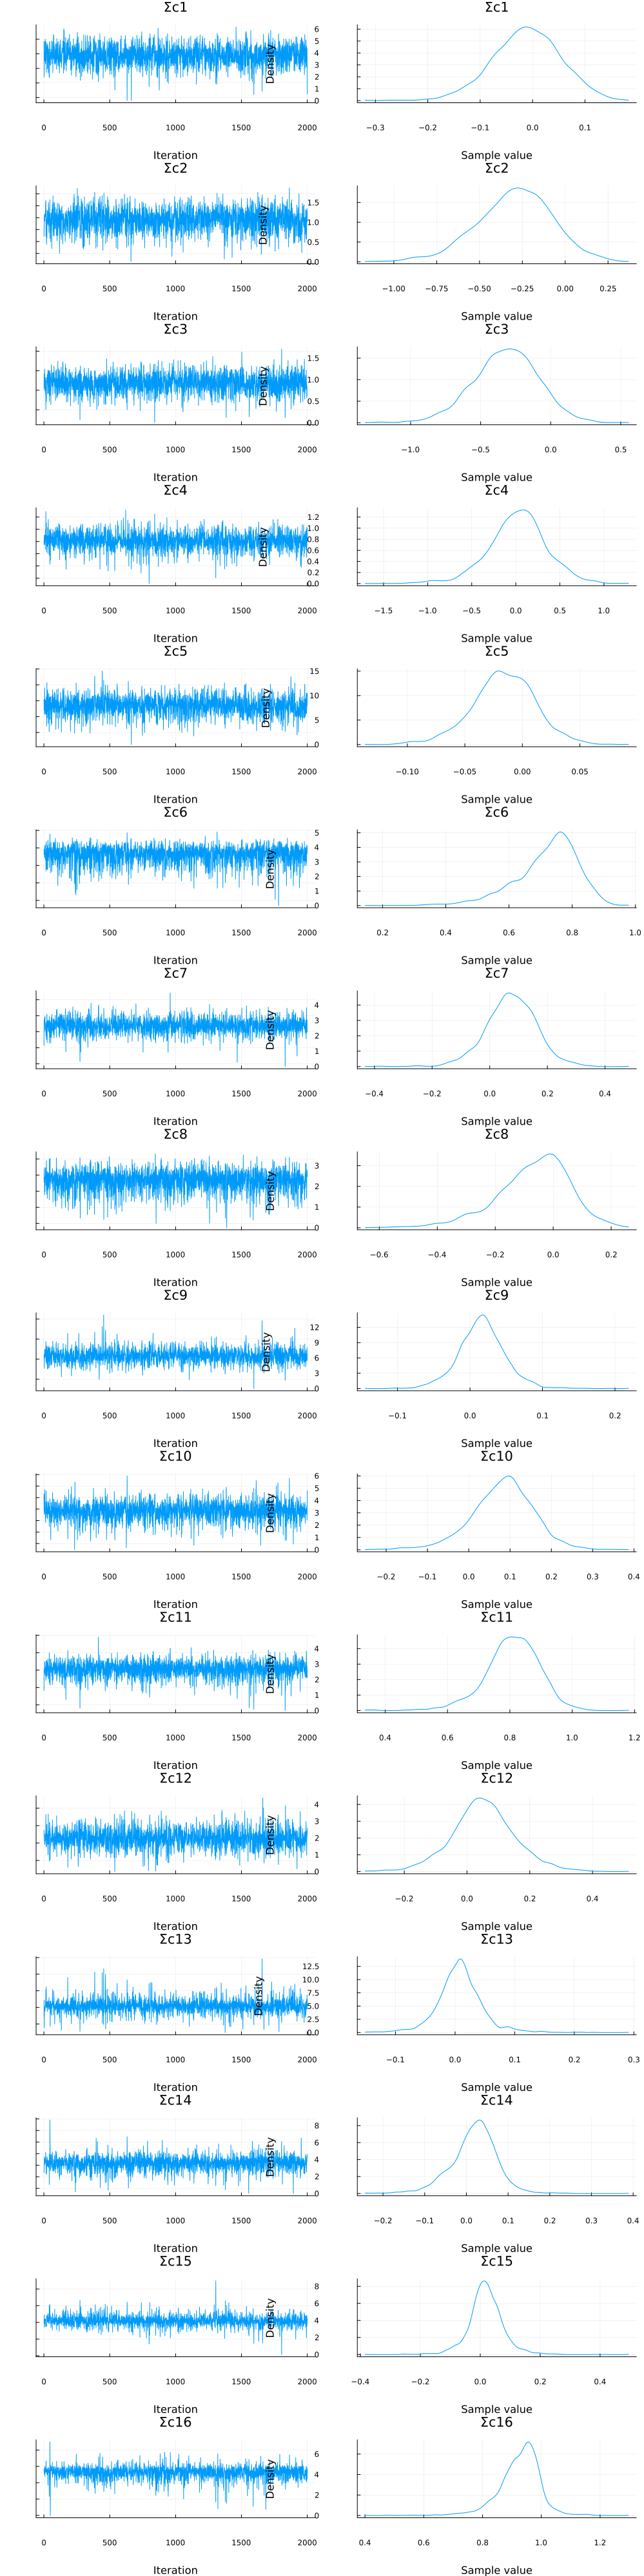

In [23]:
plot(betas_samples)

In [28]:
Σc = mean(sigmas_samples).nt.mean
Σc = reshape(Σc, n, n)
display(Σc)

β = mean(betas_samples).nt.mean
β = reshape(β, n, n*1)
display(β)

Στ = mean(trend_covariance_samples).nt.mean
Στ = reshape(Στ, 4, 4)
display(Στ)

4×4 Matrix{Float64}:
 18.7324    0.910775   0.702372    0.308285
  0.910775  3.07597    1.76009     0.207753
  0.702372  1.76009    3.25107    -0.0228907
  0.308285  0.207753  -0.0228907   1.39486

4×4 Matrix{Float64}:
 -0.0117758  -0.0162765  0.0165275  0.00809477
 -0.295249    0.720083   0.0819385  0.0180327
 -0.320718    0.0746047  0.808207   0.0186006
  0.0197004  -0.0692223  0.0527931  0.925515

4×4 Matrix{Float64}:
  0.00814223   -3.84855e-5  0.000255915  3.73102e-5
 -3.84855e-5    0.0225448   0.00666975   0.00691131
  0.000255915   0.00666975  0.0208549    0.00635742
  3.73102e-5    0.00691131  0.00635742   0.0212547

In [30]:
display(diag(Σc) .^ .5)

display(diag(Στ) .^ .5)

4-element Vector{Float64}:
 4.328096232551879
 1.7538436630465426
 1.8030736848913076
 1.1810400427060046

4-element Vector{Float64}:
 0.09023430479874514
 0.15014912558630508
 0.1444123195867452
 0.1457899122455333

In [70]:
model = tc_var(observation_tend_mapping, β, Στ, Σc, priors.initial_trend_mean, priors.initial_cycle_mean, priors.initial_trend_covariance, priors.cycle_covariance_mean)

initial_states = [trend_states_mean[end,:]; cycle_states_mean[end,:]]

n_samples = 2_000
T = 40
states = zeros(n_samples, T, 8)

observations = zeros(n_samples, T, n)

for s in 1:2_000
    states[s, :, :], observations[s, :, :] = sample(model, initial_states, T)
end


In [81]:
transformed_scenarios = permutedims(observations, (3, 2, 1))[[1,2],:,:] ./400
periods = [1,5, 10]
freq = 4
assets_names = ["GDP", "CPI"]
ret_in_years = cum_returns_in_periods(transformed_scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:2
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

Means 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 0.0195 
 0.0216 
 
 
 5 
 0.0174 
 0.0257 
 
 
 10 
 0.0172 
 0.0264

Standard devations 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 0.0191 
 0.0142 
 
 
 5 
 0.0097 
 0.0189 
 
 
 10 
 0.0074 
 0.0161

Skewness 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 0.0447 
 0.0255 
 
 
 5 
 0.0666 
 0.0941 
 
 
 10 
 0.057 
 0.0189

Kurtosis 
 
 
 
 GDP 
 CPI 
 
 
 
 
 1 
 -0.093 
 -0.0248 
 
 
 5 
 0.0956 
 0.1083 
 
 
 10 
 0.0581 
 0.0222

GDP 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 1 
 -0.0237 
 -0.0176 
 -0.0124 
 0.0068 
 0.0193 
 0.0321 
 0.0516 
 0.0574 
 0.0633 
 
 
 5 
 -0.0054 
 -0.0015 
 0.0018 
 0.0108 
 0.0174 
 0.0238 
 0.034 
 0.037 
 0.0404 
 
 
 10 
 0.0006 
 0.0029 
 0.0049 
 0.0123 
 0.0172 
 0.0223 
 0.0294 
 0.0316 
 0.0346

CPI 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 1 
 -0.0128 
 -0.006 
 -0.002 
 0.0121 
 0.0213 
 0.0312 
 0.0444 
 0.0502 
 0.0563 
 
 
 5 
 -0.0174 
 -0.0104 
 -0.0042 
 0.0129 
 0.0254 
 0.0384 
 0.0579 
 0.0646 
 0.0707 
 
 
 10 
 -0.0115 
 -0.0049 
 -0.0006 
 0.0154 
 0.0261 
 0.037 
 0.0538 
 0.0582 
 0.0648

In [85]:
transformed_scenarios = permutedims(observations[:,:,[3,4]] , (3, 2, 1))

periods = [4,20,40]
freq = 4
assets_names = ["ShortRate", "LongRate"]
ret_in_years = transformed_scenarios[:,periods,:]
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:2
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

Means 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 4 
 3.297 
 4.5079 
 
 
 20 
 2.8792 
 4.3078 
 
 
 40 
 2.7784 
 4.1444

Standard devations 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 4 
 3.1718 
 1.9871 
 
 
 20 
 4.2924 
 3.4319 
 
 
 40 
 4.493 
 3.6512

Skewness 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 4 
 0.1007 
 -0.0678 
 
 
 20 
 0.0286 
 -0.03 
 
 
 40 
 -0.0341 
 0.0222

Kurtosis 
 
 
 
 ShortRate 
 LongRate 
 
 
 
 
 4 
 0.1373 
 -0.0252 
 
 
 20 
 -0.1418 
 0.0387 
 
 
 40 
 0.2346 
 -0.1154

ShortRate 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 4 
 -3.9037 
 -2.7748 
 -1.8755 
 1.2018 
 3.2553 
 5.3977 
 8.6791 
 9.7186 
 10.8812 
 
 
 20 
 -6.7467 
 -5.392 
 -3.9903 
 -0.0278 
 2.8725 
 5.8849 
 9.7624 
 11.3608 
 12.8419 
 
 
 40 
 -8.1213 
 -5.8948 
 -4.6124 
 -0.1745 
 2.7933 
 5.7121 
 10.39 
 11.6874 
 13.2741

LongRate 
 
 
 
 0.01 
 0.025 
 0.05 
 0.25 
 0.5 
 0.75 
 0.95 
 0.975 
 0.99 
 
 
 
 
 4 
 -0.4676 
 0.6509 
 1.2511 
 3.1742 
 4.4782 
 5.8831 
 7.676 
 8.3464 
 9.0002 
 
 
 20 
 -3.7387 
 -2.4602 
 -1.4714 
 2.0604 
 4.4541 
 6.6153 
 9.7384 
 10.8681 
 12.3472 
 
 
 40 
 -4.1735 
 -3.249 
 -1.878 
 1.691 
 4.2175 
 6.6002 
 10.1357 
 11.4372 
 12.8778

In [39]:

display("gdp")
quantile(observations[:, 40, 1], [.01, .05, .25, .5, .75, .95, .99])

"gdp"

7-element Vector{Float64}:
 -8.389939315023348
 -5.619343335544899
 -1.168039066303633
  1.690706512057083
  4.754900895329
  8.736666278250139
 11.310017061102252

In [38]:
display("inflation")
quantile(observations[:, 40, 2], [.01, .05, .25, .5, .75, .95, .99])

"inflation"

7-element Vector{Float64}:
 -5.435059700858381
 -3.274011283852477
  0.3527505474919981
  2.7222468212408506
  5.167779677922851
  8.557109672908316
 10.67909284302465

In [40]:
display("short rate")
quantile(observations[:, 40, 3], [.01, .05, .25, .5, .75, .95, .99])

"short rate"

7-element Vector{Float64}:
 -7.184846214771939
 -4.206518399100824
  0.09211023403183069
  3.0329045597804667
  5.872889924777447
 10.27551020460863
 12.916931274159124

In [41]:
display("long rate")
quantile(observations[:, 40, 4], [.01, .05, .25, .5, .75, .95, .99])

"long rate"

7-element Vector{Float64}:
 -4.709578795170911
 -2.0898502350907067
  1.4924733095311709
  4.080887297972679
  6.678991119409131
 10.298119848734292
 12.31614569124956